## Run this cell first
This imports the relevant libraries we will be using, sets up some paths and logging, and defines the 'show_satellite_image' function - a very basic image display utility using Matplotlib.

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

sen2cor_path = r"/opt/Sen2Cor-02.05.05-Linux64/bin/L2A_Process"
import pyeo.filesystem_utilities
import pyeo.raster_manipulation
import pyeo.queries_and_downloads
import matplotlib.pyplot as plt
import gdal
import pprint
import os

pyeo.filesystem_utilities.init_log("training_log.log")

def show_satellite_image(image_path):
    img = gdal.Open(image_path)
    array = img.GetVirtualMemArray()
    if len(array.shape) >= 3:
        img_view = array.transpose([1,2,0])
    else:
        img_view = array
    plt.imshow(img_view)
    img_view = None
    array = None
    img = None

2019-10-29 07:19:58,469: INFO: ****PROCESSING START****


## Useful to know:

For quick help on any Python function, run the line 

```python
?function_name
```
in a cell.
To see this in action, try 
```python
?pyeo.queries_and_downloads.download_s2_data
```
Pressing Tab will give you a list of possible completion of these functions.


## Step 0: Sign up to the Copernicus OA hub
If you have not done so, go to https://scihub.copernicus.eu/ and create a username and password.

Fill in the first two lines of kinangop.ini with these.

## Step 1: Load the configuration file



This step uses the Python modle ConfigParser.

A Configuration File is a way of recording a set of values such that Python can understand them.

If you run the below cell, you should see your Scihub username appear.


In [2]:
import configparser
conf = configparser.ConfigParser()
conf.read("kinangop.ini")
conf['sent_2']['user']

'jfr10'

 ## Step 2: Choose and download images
Open up kinangop_rough.json and have a look. To see the area mapped, open www.geojson.io and paste the contents of the file; you should see the polygon.

We will be using a high-level Pyeo function for this part of the practical:
```Python
query_results = pyeo.queries_and_downloads.check_for_s2_data_by_date(
    "path/to/json",
    date_1,
    date_2,
    conf,
    maximum_cloud_cover)
```
This function searches for Sentinel 2 data between the given dates and saves the 

All dates and values are passed as strings.

Each date is in the format "yyyymmdd"; for example, the 14th February, 2016 would be "20160214".

The cloud cover is in percent; setting this to '50' would find 

`conf` is the object you made in step 1.

For example, to check for images in **Kinangop** between **25th December, 2017** and **1st of January, 2018** with less than **30%** cloud cover, you would do this:

```python
query_results = pyeo.queries_and_downloads.check_for_s2_data_by_date(
    "kinangop_rough.json",
    "20171225",
    "20180101",
    conf,
    "30"
)
```

You can see the results with ```pprint.pprint(query_results)```

You may notice that some images are level 1C (```L1C```) and some are level 2A (```L2A```). For this course, we only want level 1C images - we will carry out our own atmospheric correction using Sen2Cor.
There are a set of functions in queries_and_rasters that filter for this - the one you would use is

```python
filtered_query_results = pyeo.queries_and_downloads.filter_to_l1_data(not_filtered_query_results)
```


## Exercise 1: Search for all images in the first week of January 2019 with less than 60% cloud cover. Filter this list to only level 1 images.


In [3]:
query_results = pyeo.queries_and_downloads.check_for_s2_data_by_date(
    "kinangop_rough.json",
    "20171225",
    "20180113",
    conf,
    "30"
)

2019-10-29 06:16:01,431: INFO: Querying for imagery between 20171225 and 20180113 for aoi kinangop_rough.json
2019-10-29 06:16:01,438: INFO: Sending query:
footprint: POLYGON((36.6123 -0.5949,36.6293 -0.6657,36.6627 -0.7148,36.6859 -0.7013,36.6863 -0.7012,36.6867 -0.7009,36.6948 -0.6807,36.6895 -0.6439,36.6894 -0.6436,36.6778 -0.6129,36.6540 -0.5556,36.6216 -0.5369,36.6123 -0.5949))
start_date: 2017-12-25T00:00:00Z
end_date: 2018-01-13T00:00:00Z
 cloud_cover: 30 
2019-10-29 06:16:02,544: INFO: Search returned 1 images


## Step 3: Download the images you found in step 2

The Pyeo function ```pyeo.queries_and_downloads.download_s2_data()``` takes the results from check_for_s2_data_by_date() and downloads the images from either Scihub or AWS. You call it like this:

```python
pyeo.queries_and_downloads.download_s2_data(
    new_data,
    l1_out_folder,
    l2_out_folder,
    source='scihub',
    user=your_username,
    passwd=your_password,
)
```

```new_data``` is the output from step 1.

```l1_out_folder``` is the directory that any level 1 images will be downloaded to.

```l2_out_folder``` is the directory that any level 2 images will be downloaded to. You can set this to None if you are not downloading level 2 images.

```source``` is the source of the data; at present, download_s2_data supports the Copernicus hub (```"scihub"```) and the public AWS S2 dataset (```"aws"```) as it's source.
Work for supporting Google Cloud is ongoing.

```user``` and ```passwd``` are your Copernicus username and password, that you created in step 0.

It is bad practice to have your password typed into your script. You should store it in a file and load it when needed.

With that in mind, you can extract your username and password from ```conf``` by using the following snippet:
```python
user = conf["sent_2"]["user"]
passwd = conf["sent_2"]["pass"]
```

## Exercise 2: Create a new folder called "images". Download the sentinel 2 products from step 2 into this folder.
You will need to create this folder in the Jupyter browser that you opened this notebook from.

In [2]:
pyeo.queries_and_downloads.download_s2_data(
    new_data = query_results,
    l1_dir = 'images',
    l2_dir = 'images',
    source = 'scihub',
    user = conf["sent_2"]["user"],
    passwd = conf["sent_2"]["pass"]
)

NameError: name 'query_results' is not defined

## Step 4: Explore and view your image 

Open up your "images" folder; you should see some folders ending in .SAFE. These are your sentinel 2 L1 images.

Normally, you would open up a program like QGis or ArcGIS to view these images. In this context, that is not possible so instead use the following snippet of code to view an image:

```python
%matplotlib inline
show_satellite_image(image_path)
```

## Exercise 3: View the quicklook of both your images

In each .SAFE file, there is a RGB image that acts as a low-resolution preview. This file ends with TCL.jp2. Search through each of your .SAFE files and find the path to it, then use the above snippet to display it.

/home/jupyter-jfr10


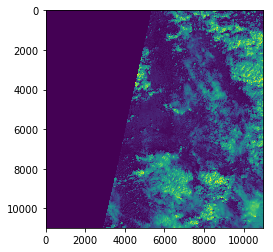

In [18]:
%matplotlib inline
print(os.getcwd())
image_path =r"images/S2B_MSIL2A_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE/GRANULE/L2A_T36MZE_A009556_20190104T075257/IMG_DATA/R10m/T36MZE_20190104T074319_B04_10m.jp2"
show_satellite_image(image_path)

## Step 5: Pre-process to Level 2 data

At present, the images you have downloaded are not accurate - they do not take the effects of the atmosphere into account. ESA provide an out-of-the-box program, Sen2Cor, to correct this.

Sen2Cor is normally called from the command line, but Pyeo provides a function to automate this.
```python
l2_path = pyeo.raster_manipulation.apply_sen2cor(
    image_path,
    sen2cor_path
)
```

This function calls L2A_Process (the relevent part of sen2cor) on the .SAFE file at image_path. It produces a level 2 .SAFE file at the same location, stored in l2_path

So, the following snippet would process the .SAFE file my_safe_file:

```python
l2_path = pyeo.raster_manipulation.apply_sen2cor(
    "images/my_safe_file",
    sen2cor_path
)
print(l2_path)
```

You _could_ call pyeo.raster_manipulation.apply_sen2cor on each of your images in turn, by hand. This is fine if you only have a few images, but will get tedious very quickly for 100.

You can use the following snippet to get the name of every file in your directory in a list.

```python
file_list = os.listdir("my/folder")
```

In the same vein, you can use the following snippet to do a function for every item of a list.

```python
for thing in list:
    function(thing)
```

Finally,

```python
path = os.path.join("images", "my_s2_image")
```
will produce a filepath to my_s2_image.

## Exercise 4: Write a short script to preprocess the images you downloaded.

This will take around 30 minutes per image. Combine the three snippets above to call apply_sen2cor to each .SAFE folder in "images" you have downloaded.


In [5]:
import subprocess
image_path = "images/S2B_MSIL1C_20180109T074259_N0206_R092_T37MBV_20191029T055008.SAFE"
print(os.path.abspath(image_path))
sen2cor_proc = subprocess.run([sen2cor_path, image_path,],
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                    universal_newlines=True)

sen2cor_proc

2019-10-29 07:21:58,850: INFO: calling subprocess: ['/opt/Sen2Cor-02.05.05-Linux64/bin/L2A_Process', 'images/S2B_MSIL1C_20180109T074259_N0206_R092_T37MBV_20191029T055008.SAFE']
2019-10-29 07:21:59,685: INFO: sen2cor processing finished for images/S2B_MSIL1C_20180109T074259_N0206_R092_T37MBV_20191029T055008.SAFE
2019-10-29 07:21:59,687: INFO: Validating:
2019-10-29 07:22:00,565: INFO: Checking images/S2B_MSIL2A_20180109T074259_N9999_R092_T37MBV_20191029T072158.SAFE for incomplete 10m imagery
2019-10-29 07:22:00,567: ERROR: 10m imagery not present in images/S2B_MSIL2A_20180109T074259_N9999_R092_T37MBV_20191029T072158.SAFE


BadS2Exception: 

## Further work

We will continue with the main processing chain tomorrow. If you have reached this point, try the following exercises:

* The following snippet uses GDAL to open an image.

```python
import gdal
image = gdal.Open("path/to/image")
```

There is a Python concept known as an 'object'. An 'object' contains a set of 'methods' (things the object can do) and 'attributes' (values that define what the object is).

From the above snippet, `image` is an object containing methods and attributes. To get a list of these methods and attributes, use the command dir(image). To call them, use image.function() or image.attribute

### Using gdal.Open, find out the height, width and number of bands in the quicklook.

* ```array = image.ReadAsArray()``` lets you open an image as a Numpy array. This lets you inspect the pixels directly.
  
  A Gdal image array is of the order (bands, y, x), so to access the pixel at **x=100**, **y = 500** of the **1st band**, you would use 
  ```python
  array[0, 499, 99]
  ```
  
  Python (and most other languages) count from 0 for this, so the first band has an index of 0, the second band has an index of 1 and so on.

### Using the examples at https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html, find the mean pixel value of each band of your quicklook.

### Further further work - calculate and display an NDVI layer for each of your images.
